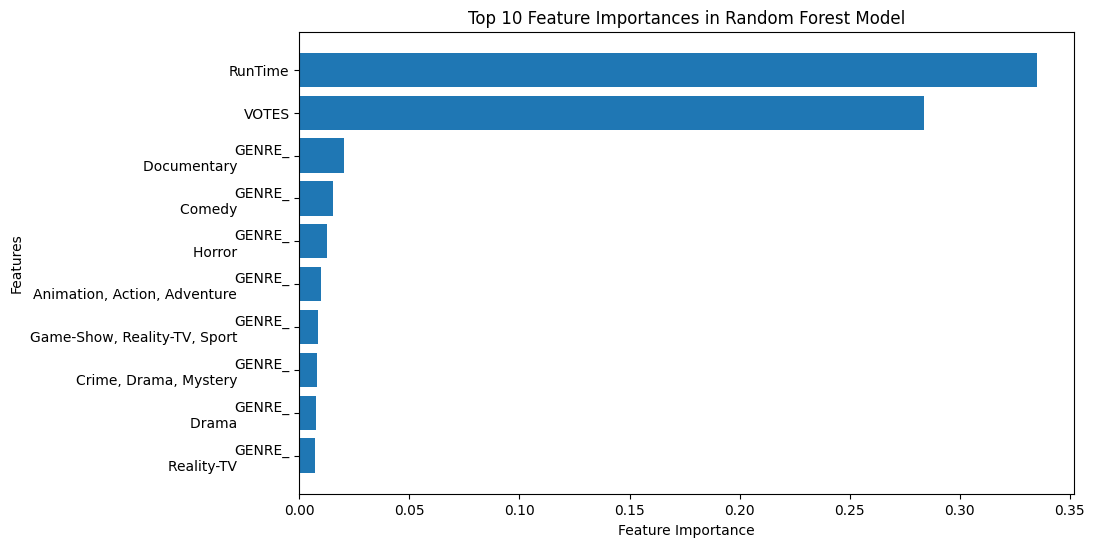

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the dataset
file_path = './movies.csv'
movies_df = pd.read_csv(file_path)

# Preprocessing
# Selecting relevant columns and handling missing values
simplified_df = movies_df[['GENRE', 'RATING', 'VOTES', 'RunTime']].dropna(subset=['RATING'])
simplified_df['VOTES'] = simplified_df['VOTES'].str.replace(',', '').astype(int)

# Imputing missing values
imputer = SimpleImputer(strategy='median')
simplified_df[['VOTES', 'RunTime']] = imputer.fit_transform(simplified_df[['VOTES', 'RunTime']])
simplified_df = simplified_df.dropna(subset=['GENRE'])

# Feature and target separation
X = simplified_df[['GENRE', 'VOTES', 'RunTime']]
y = simplified_df['RATING']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('genre', OneHotEncoder(handle_unknown='ignore'), ['GENRE']),
        ('num', StandardScaler(), ['VOTES', 'RunTime'])
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVR())
])
svm_pipeline.fit(X_train, y_train)

# Random Forest Model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', random_forest)
])
rf_pipeline.fit(X_train, y_train)

# Predictions and Performance Metrics
y_pred_rf = rf_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = rf_pipeline.score(X_test, y_test)

# Extracting feature importances from the Random Forest model
feature_importances = rf_pipeline.named_steps['random_forest'].feature_importances_

# Getting feature names from the preprocessing step
# Extracting one-hot encoded genre feature names
encoded_feature_names = preprocessor.named_transformers_['genre'].get_feature_names_out(input_features=['GENRE'])
# Combining with other numeric feature names
feature_names = np.concatenate((encoded_feature_names, ['VOTES', 'RunTime']))

# Creating a DataFrame for easier handling
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting by importance and selecting the top most important features for clarity in visualization
top_features = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances in Random Forest Model')
plt.gca().invert_yaxis() # Invert y-axis for better readability
plt.show()
